# 线性回归的简洁实现
[3.3节](./03.linear-networks.ipynb#线性回归的简洁实现)
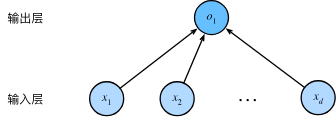
$$\hat{y} = w_1  x_1 + ... + w_d  x_d + b = \mathbf{w}^\top \mathbf{x} + b,\ where\ \mathbf{x} \in \mathbb{R}^d, \mathbf{w} \in \mathbb{R}^d$$
$${\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b,\ where\ \mathbf{X} \in \mathbb{R}^{n \times d}$$
$\mathbf{X}$的每一行是一个样本.
Sequential类将多个层串联在一起

In [ ]:
import torch, random
from torch import nn
from torch.utils import data
from matplotlib import pyplot as plt

# 生成数据集
def synthetic_data(w, b, num_examples):
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

print(features.size())
print(labels.size())
# plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)

# 读取数据集
batch_size = 10
data_iter = data.DataLoader(data.TensorDataset(features, labels), batch_size=batch_size, shuffle=True)
X, y = next(iter(data_iter))
print("X =\n", X)
print("y =\n", y)

# 定义模型
net = nn.Sequential(nn.Linear(2, 1))
print(net)

# 参数初始化
"""
1. 通过`net[0]`选择网络中的第一个图层
2. 使用`weight.data`和`bias.data`方法访问参数
3. 使用替换方法`normal_`和`fill_`来重写参数值
"""
print(net[0].weight.data)
print(net[0].bias.data)
print(net[0].weight.data.normal_(0, 0.01))
print(net[0].bias.data.fill_(1))

# 验证模型和初始化参数
y_hat = torch.matmul(X, net[0].weight.data.T) + net[0].bias.data
print(torch.equal(y_hat, net(X)))

# 损失函数
loss = nn.MSELoss()

# 验证损失函数值
torch.sum((y_hat - y) ** 2)/y.numel()
loss(net(X) ,y)

# 优化算法
"""待优化的参数可通过net.parameters()获得"""
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

# 训练
num_epochs = 3
for epoch in range(num_epochs):
    if isinstance(net, torch.nn.Module):
        net.train()         # 将模型设置为训练模式
    for X, y in data_iter:
        l = loss(net(X) ,y) # 计算损失函数loss（前向传播）
        trainer.zero_grad()
        l.backward()        # 进行反向传播来计算梯度
        trainer.step()      # 用优化器来更新模型参数
    
    if isinstance(net, torch.nn.Module):
        net.eval()          # 将模型设置为评估模式
    with torch.no_grad():
        l = loss(net(features), labels)
        print(f'epoch {epoch + 1}, loss {l:f}')

w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

# softmax回归的简洁实现
[3.7节](./03.linear-networks.ipynb#softmax回归的简洁实现)  
$n$样本数量, $d$单个样本的输入维度, $q$单个样本的输出维度, 即种类总数  
单个样本的loss:
$$\begin{split}\begin{aligned}
l(\mathbf{y}, \hat{\mathbf{y}}) &= - \sum_{j=1}^q y_j \log \hat{y}_j \ (\because \hat{y}_j = \mathrm{softmax}(o_j) = \frac{\exp(o_j)}{\sum_{k=1}^q \exp(o_k)})\\
&=  - \sum_{j=1}^q y_j \log \frac{\exp(o_j)}{\sum_{k=1}^q \exp(o_k)} \\
&= \sum_{j=1}^q y_j \log \sum_{k=1}^q \exp(o_k) - \sum_{j=1}^q y_j o_j \ (\because \sum_{j=1}^q y_j = 1)\\
&= \log \sum_{k=1}^q \exp(o_k) - \sum_{j=1}^q y_j o_j
\end{aligned}\end{split}$$
其导数:
$$ \frac{\partial  l(\mathbf{y}, \hat{\mathbf{y}})}{\partial {o_j}} = \frac{\exp(o_j)}{\sum_{k=1}^q \exp(o_k)} - y_j = \mathrm{softmax}(o_j) - y_j $$

$n$个样本的loss:
$$ \sum_{i=1}^n l(\mathbf{y}^{(i)}, \hat{\mathbf{y}}^{(i)})$$

In [ ]:
import torch, torchvision, time
from torch import nn
from torchvision import transforms
from torch.utils import data
from matplotlib import pyplot as plt
from IPython import display

# 下载数据集
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="../../temp", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST( root="../../temp", train=False, transform=trans, download=True)
print("训练集中的样本数量 =", len(mnist_train), ", 测试集中的样本数量", len(mnist_test))
print("size of input of first sample =", mnist_train[0][0].shape)
print("label of first sample =", mnist_train[0][1])

# 读取数据集
## 部分数据可视化
def get_fashion_mnist_labels(labels):
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes
batch_size = 10
data_iter = data.DataLoader(mnist_train,
                            batch_size=batch_size,
                            shuffle=True,  # 随机打乱所有样本
                            num_workers=4) # 使用4个进程来读取数据                                                              

X, y = next(iter(data_iter))
show_images(X.reshape(batch_size, 28, 28), 2, int(batch_size/2), titles=get_fashion_mnist_labels(y))

## 多进程来读取数据对比
start = time.time()
for X, y in data.DataLoader(mnist_train, batch_size=256):
    continue
end = time.time()
print(end - start, "sec")

start = time.time()
for X, y in data.DataLoader(mnist_train, batch_size=256, num_workers=4):
    continue
end = time.time()
print(end - start, "sec")

## 训练和测试数据
batch_size = 256
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=4)
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=True, num_workers=4)

# 定义模型
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))
print(net)

# 参数初始化
for ii in range(len(net)):
    print(ii, type(net[ii]) == nn.Linear)
net[1].weight.data.normal_(0.0, 0.01) # 方法1
# nn.init.normal_(net[1].weight, mean=0.0, std=0.01) # 方法2
print(net[1].weight.data)

# 损失函数
loss = nn.CrossEntropyLoss(reduction='none')

# 验证
## 验证 softmax 函数
X2 = torch.normal(0, 1, (2, 5))
print("X2 =\n", X2)
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition
X_prob = softmax(X2)
print("X_prob =\n", X_prob)
### 分步验证
X_exp = torch.exp(X2)
print("X_exp =\n", X_exp)
partition = X_exp.sum(1, keepdim=True)
print("partition =\n", partition)
X_prob = X_exp / partition
print("X_prob =\n", X_prob)
print("sum of X_prob = ", X_prob.sum(1))

## 验证模型和初始参数
X, y = next(iter(data_iter))
Output = torch.matmul(X.reshape((-1, net[1].weight.data.T.shape[0])), net[1].weight.data.T) + net[1].bias.data
print(torch.equal(Output, net(X)))

## 验证loss
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])
y_hat = softmax(Output)
print("y =", y)
print(cross_entropy(y_hat, y))
print(loss(net(X) ,y))

# 优化算法
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

# 训练
## 准备(累加器和动画)
class Accumulator: # 累加器
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: self.set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
        
    def set_axes(self, axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """Set the axes for matplotlib"""
        axes.set_xlabel(xlabel)
        axes.set_ylabel(ylabel)
        axes.set_xscale(xscale)
        axes.set_yscale(yscale)
        axes.set_xlim(xlim)
        axes.set_ylim(ylim)
        if legend:
            axes.legend(legend)
        axes.grid()
        
    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

## 定义分类正确函数
"""分类概率->分类结果"""
def accuracy(y_hat, y):
    """计算分类正确次数"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())
### 分步验证
if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
    y_hat = y_hat.argmax(axis=1)
print("y_hat =", y_hat) 
print("y =    ", y) # y_hat & y defined in 验证loss
cmp = y_hat.type(y.dtype) == y # 由于等式运算符“==”对数据类型很敏感， 因此我们将y_hat的数据类型转换为与y的数据类型一致
print("cmp =  ", cmp)
print("分类正确的次数 =", float(cmp.type(y.dtype).sum()))

## 使用训练集，训练模型
def train(net, train_iter, loss, optimizer):
    if isinstance(net, torch.nn.Module):
        net.train()                    # 将模型设置为训练模式
    metric = Accumulator(3)            # 累加器
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)             # 计算损失函数loss（前向传播）
        optimizer.zero_grad()
        l.mean().backward()            # 进行反向传播来计算梯度
        optimizer.step()               # 用优化器来更新模型参数

        metric.add(float(l.sum()),     # 训练损失总和
                   accuracy(y_hat, y), # 训练准确度总和
                   y.size(0))          # 样本数
    return metric[0] / metric[2], metric[1] / metric[2] # 返回训练集的平均损失和分类准确率

## 使用测试集，评估模型
def evaluate(net, test_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()                          # 将模型设置为评估模式
    metric = Accumulator(2)                 # 累加器
    with torch.no_grad():
        for X, y in test_iter:
            metric.add(accuracy(net(X), y), # 当前分类正确次数
                       y.size(0))           # 当前样本数量

    return metric[0] / metric[1]           # 返回测试集的分类准确率

## 运行多个迭代周期。 在每个迭代周期结束时，利用test_iter访问到的测试数据集对模型进行评估
num_epochs = 10
animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9], legend=["train loss", "train acc", "test acc"])

for epoch in range(num_epochs):
    train_metrics = train(net, train_iter, loss, optimizer) # 训练模型
    test_acc = evaluate(net, test_iter)                     # 评估模型
    print(epoch + 1, "train loss =", train_metrics[0], ", train acc =", train_metrics[1], ", test acc =", test_acc)
    animator.add(epoch + 1, train_metrics + (test_acc,))

train_loss, train_acc = train_metrics
assert train_loss < 0.5, train_loss
assert train_acc <= 1 and train_acc > 0.7, train_acc
assert test_acc <= 1 and test_acc > 0.7, test_acc

# 预测
num_samples = 8
X, y = next(iter(data.DataLoader(mnist_test, num_samples, shuffle=True)))
labels = get_fashion_mnist_labels(y)
outputs = get_fashion_mnist_labels(net(X).argmax(axis=1))
titles = [true +'\n' + pred for true, pred in zip(labels, outputs)]
show_images(torch.squeeze(X), 1, num_samples, titles=titles)

# 带参数注意力汇聚
[10.2.4节](./10.attention-mechanisms.ipynb#带参数注意力汇聚)

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# ---------------------- x_train, keys, values ----------------------

n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5) # 排序后的训练样本
def f(x):
    return 2 * torch.sin(x) + x**0.8
y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,)) # 训练样本的输出

# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))

# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

# ---------------------- training ----------------------

class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = torch.reshape(x_train.repeat_interleave(keys.shape[1]), (-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(-((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1)

net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')

# ---------------------- verification ----------------------

def plot_kernel_reg(y_hat):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x_test, y_truth, label='Truth')
    ax.plot(x_test, y_hat, label='Pred', linestyle='--')
    ax.plot(x_train, y_train, 'o', alpha=0.5);
    ax.legend(loc='upper right')
    ax.set_xlim([0, 5])
    ax.set_ylim([-1, 5])
    ax.grid(True)
    
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))

y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

# ---------------------- attention weights ----------------------

def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(16, 9),
                  cmap='Reds'):
    """显示矩阵热图"""
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
              xlabel='Sorted training inputs',
              ylabel='Sorted testing inputs')